Voice verification model

In [23]:
# Install Required Dependencies
# Run this cell first to install all required packages
# This uses the Jupyter kernel's Python environment

import sys
import subprocess
import platform

def install_package(package, upgrade=False):
    """Install a package using pip in the current Python environment"""
    try:
        cmd = [sys.executable, "-m", "pip", "install"]
        if upgrade:
            cmd.append("--upgrade")
        cmd.extend(["--quiet", package])
        subprocess.check_call(cmd)
        print(f"✅ {package} installed successfully")
        return True
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to install {package}: {e}")
        return False

def check_libomp():
    """Check if OpenMP library is available (required for xgboost on macOS)"""
    if platform.system() == "Darwin":  # macOS
        try:
            result = subprocess.run(["brew", "list", "libomp"], 
                                  capture_output=True, text=True)
            if result.returncode == 0:
                print("✅ OpenMP (libomp) is installed")
                return True
            else:
                print("⚠️  OpenMP (libomp) is NOT installed")
                print("   xgboost requires OpenMP on macOS.")
                print("   To install, run in terminal: brew install libomp")
                return False
        except FileNotFoundError:
            print("⚠️  Homebrew not found. Cannot check for OpenMP.")
            print("   If xgboost fails, install Homebrew and run: brew install libomp")
            return None
    return True  # Not macOS, assume OK

# Install required packages in order (dependencies first)
print("📦 Installing required packages...")
print(f"Using Python: {sys.executable}\n")

# Check for OpenMP on macOS
print("Checking for OpenMP runtime (required for xgboost on macOS)...")
libomp_available = check_libomp()

# First install scipy (required by xgboost)
print("\nInstalling scipy (xgboost dependency)...")
install_package("scipy")

# Install xgboost with upgrade to fix any corruption
print("\nInstalling xgboost...")
install_package("xgboost", upgrade=True)

# Install lightgbm
print("\nInstalling lightgbm...")
install_package("lightgbm")

# Verify installation
print("\n🔍 Verifying installations...")
XGBOOST_AVAILABLE = False
LIGHTGBM_AVAILABLE = False

try:
    import xgboost as xgb
    print("✅ xgboost import successful")
    XGBOOST_AVAILABLE = True
except Exception as e:
    print(f"❌ xgboost import failed: {e}")
    if "libomp" in str(e) or "OpenMP" in str(e):
        print("\n💡 SOLUTION: Install OpenMP runtime:")
        print("   Run this command in your terminal:")
        print("   brew install libomp")
        print("\n   Then restart the kernel and run this cell again.")
    else:
        print("   Trying to reinstall xgboost...")
        install_package("xgboost", upgrade=True)

try:
    import lightgbm as lgb
    print("✅ lightgbm import successful")
    LIGHTGBM_AVAILABLE = True
except Exception as e:
    print(f"❌ lightgbm import failed: {e}")

# Store availability in globals for use in other cells
globals()['XGBOOST_AVAILABLE'] = XGBOOST_AVAILABLE
globals()['LIGHTGBM_AVAILABLE'] = LIGHTGBM_AVAILABLE

print("\n✅ Installation complete!")
if not XGBOOST_AVAILABLE:
    print("⚠️  Note: xgboost is not available. The notebook will skip xgboost models.")


📦 Installing required packages...
Using Python: /Applications/Xcode.app/Contents/Developer/usr/bin/python3

Checking for OpenMP runtime (required for xgboost on macOS)...
✅ OpenMP (libomp) is installed

Installing scipy (xgboost dependency)...
✅ scipy installed successfully

Installing xgboost...
✅ xgboost installed successfully

Installing lightgbm...
✅ lightgbm installed successfully

🔍 Verifying installations...
✅ xgboost import successful
✅ lightgbm import successful

✅ Installation complete!


In [24]:
# Import Required Libraries
import pandas as pd
import numpy as np
import time
import sys
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           f1_score, precision_score, recall_score, roc_auc_score)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Optional imports for xgboost and lightgbm (may not be available if OpenMP is missing)
XGBOOST_AVAILABLE = False
LIGHTGBM_AVAILABLE = False

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✅ xgboost imported successfully")
except ImportError as e:
    print(f"⚠️  xgboost not available: {e}")
    print("   The notebook will skip xgboost models. Install OpenMP with: brew install libomp")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
    print("✅ lightgbm imported successfully")
except ImportError as e:
    print(f"⚠️  lightgbm not available: {e}")
    print("   The notebook will skip lightgbm models.")

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from datetime import datetime
import json
import logging
from sklearn.metrics import log_loss

warnings.filterwarnings('ignore')

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("\n✅ All core libraries imported successfully!")

✅ xgboost imported successfully
✅ lightgbm imported successfully

✅ All core libraries imported successfully!


In [25]:
# VoiceprintVerificationModel Class Definition and Test
class VoiceprintVerificationModel:
    """
    High-performance Voiceprint Verification Model with advanced features
    """
    
    def __init__(self, csv_path='audio_features.csv', random_state=42):
        """Initialize the Voiceprint Verification Model"""
        self.csv_path = csv_path
        self.random_state = random_state
        
        self.scaler = RobustScaler()
        self.label_encoder = LabelEncoder()
        
        self.models = {}
        self.best_model = None
        self.best_model_name = None
        self.best_params = None
        
        self.df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        
        self.training_results = {}
        self.model_metadata = {
            'training_timestamp': None,
            'data_shape': None,
            'feature_names': None,
            'speakers': None,
            'best_model_params': None
        }
        
        self._create_directories()
        print("✅ VoiceprintVerificationModel initialized successfully!")

    def _create_directories(self):
        """Create necessary directories for outputs"""
        directories = ['models', 'results', 'logs']
        for directory in directories:
            os.makedirs(directory, exist_ok=True)

print("Testing VoiceprintVerificationModel initialization...")
test_model = VoiceprintVerificationModel()
print(f"✅ Class created successfully! CSV path: {test_model.csv_path}")
print(f"Random state: {test_model.random_state}")
print(f"Available directories: {[d for d in ['models', 'results', 'logs'] if os.path.exists(d)]}")

Testing VoiceprintVerificationModel initialization...
✅ VoiceprintVerificationModel initialized successfully!
✅ Class created successfully! CSV path: audio_features.csv
Random state: 42
Available directories: ['models', 'results', 'logs']


In [26]:
# Data Loading and Validation Methods
def load_and_validate_data(self):
    """Load and validate the audio features dataset"""
    print("Loading and validating audio features data...")
    
    try:
        self.df = pd.read_csv(self.csv_path)
        print(f"✅ Successfully loaded data with shape: {self.df.shape}")
        
        required_columns = ['speaker']
        missing_columns = [col for col in required_columns if col not in self.df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")
        
        # Normalize speaker names
        print("\n🔧 Normalizing speaker names...")
        original_speakers = self.df['speaker'].unique()
        
        def normalize_speaker_name(name):
            """Normalize speaker names: lowercase, extract from filenames"""
            name = str(name).strip().lower()
            
            # Extract speaker name from filenames (e.g., 'samuel-approve.m4a' -> 'samuel')
            # Remove file extensions and common prefixes
            if '.' in name:
                # Remove file extension
                name = name.split('.')[0]
            if '-' in name:
                # For patterns like 'samuel-approve', 'samuel-confirm', take first part
                parts = name.split('-')
                # Check if first part is a common name (not a filename pattern)
                if len(parts) > 1 and parts[0] in ['david', 'patrick', 'samuel', 'jeremiah', 'armand', 'christian']:
                    name = parts[0]
            
            return name
        
        self.df['speaker'] = self.df['speaker'].apply(normalize_speaker_name)
        
        print(f"Speaker names normalized:")
        print(f"  Before: {sorted(original_speakers)}")
        print(f"  After:  {sorted(self.df['speaker'].unique())}")
        
        mfcc_columns = [col for col in self.df.columns if 'mfcc' in col.lower()]
        if len(mfcc_columns) == 0:
            raise ValueError("No MFCC features found in the dataset")
        
        print("\n=== DATA VALIDATION REPORT ===")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Speakers: {sorted(self.df['speaker'].unique())}")
        print(f"Number of speakers: {self.df['speaker'].nunique()}")
        
        if 'augmentation_type' in self.df.columns:
            print(f"Augmentation types: {sorted(self.df['augmentation_type'].unique())}")
        
        print(f"\nClass distribution:")
        class_counts = self.df['speaker'].value_counts()
        print(class_counts)
        
        # Warn about classes with insufficient samples
        insufficient_classes = class_counts[class_counts < 2]
        if len(insufficient_classes) > 0:
            print(f"\n⚠️ Warning: {len(insufficient_classes)} class(es) have less than 2 samples:")
            print(insufficient_classes)
            print("   Stratified splitting will not be used for these classes.")
        
        missing_values = self.df.isnull().sum()
        if missing_values.any():
            print(f"\n⚠️ Missing values found:")
            print(missing_values[missing_values > 0])
        
        self.model_metadata['data_shape'] = self.df.shape
        self.model_metadata['speakers'] = sorted(self.df['speaker'].unique())
        
        print("\n✅ Data validation completed successfully")
        return self.df
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        raise

VoiceprintVerificationModel.load_and_validate_data = load_and_validate_data

print("Testing data loading with actual audio features...")

csv_path = '../data/outputs/audio_features.csv'
print(f"Attempting to load: {csv_path}")

if os.path.exists(csv_path):
    print("✅ Found audio_features.csv file!")
    test_model = VoiceprintVerificationModel(csv_path=csv_path)
    loaded_data = test_model.load_and_validate_data()
    print(f"✅ Data loading successful!")
    print(f"Total samples: {len(loaded_data)}")
    print(f"Samples per speaker: {loaded_data['speaker'].value_counts().to_dict()}")
else:
    print(f"❌ File not found at {csv_path}")
    print("Available files in current directory:")
    print([f for f in os.listdir('.') if f.endswith('.csv')])
    
    if os.path.exists('data'):
        print("Files in data/ directory:")
        for root, dirs, files in os.walk('data'):
            for file in files:
                if file.endswith('.csv'):
                    print(f"  {os.path.join(root, file)}")
    
    print("\n📝 Note: Update the csv_path variable to match your actual file location")

if os.path.exists('test_audio_features.csv'):
    os.remove('test_audio_features.csv')
    print("🧹 Cleaned up test_audio_features.csv (not needed for assignment)")

Testing data loading with actual audio features...
Attempting to load: ../data/outputs/audio_features.csv
✅ Found audio_features.csv file!
✅ VoiceprintVerificationModel initialized successfully!
Loading and validating audio features data...
✅ Successfully loaded data with shape: (8, 16)

🔧 Normalizing speaker names...
Speaker names normalized:
  Before: ['David', 'david', 'patrick', 'samuel-approve-audio.mp4', 'samuel-approve.m4a', 'samuel-confirm-transaction-audio.mp4', 'samuel-confirm.m4a']
  After:  ['david', 'patrick', 'samuel']

=== DATA VALIDATION REPORT ===
Dataset shape: (8, 16)
Speakers: ['david', 'patrick', 'samuel']
Number of speakers: 3
Augmentation types: ['original']

Class distribution:
speaker
samuel     4
david      2
patrick    2
Name: count, dtype: int64

✅ Data validation completed successfully
✅ Data loading successful!
Total samples: 8
Samples per speaker: {'samuel': 4, 'david': 2, 'patrick': 2}


In [33]:
# Feature Engineering Methods
def engineer_features(self):
    """Advanced feature engineering and selection"""
    print("Performing feature engineering...")
    
    # Get feature columns (excluding labels)
    exclude_cols = ['speaker', 'augmentation_type']
    feature_cols = [col for col in self.df.columns if col not in exclude_cols]
    
    # Store original feature names
    self.feature_names = feature_cols
    
    # Extract features and labels
    X = self.df[feature_cols].values
    y = self.df['speaker'].values
    
    print("=== FEATURE ENGINEERING ===")
    print(f"Original features: {len(feature_cols)}")
    
    # Add derived MFCC features
    mfcc_cols = [i for i, col in enumerate(feature_cols) if 'mfcc' in col.lower()]
    if len(mfcc_cols) > 1:
        mfcc_data = X[:, mfcc_cols]
        mfcc_std = np.std(mfcc_data, axis=1).reshape(-1, 1)
        mfcc_range = (np.max(mfcc_data, axis=1) - np.min(mfcc_data, axis=1)).reshape(-1, 1)
        
        # Combine features
        X_enhanced = np.hstack([X, mfcc_std, mfcc_range])
        enhanced_feature_names = feature_cols + ['mfcc_std', 'mfcc_range']
        
        print(f"Enhanced features: {len(enhanced_feature_names)}")
        
        X = X_enhanced
        self.feature_names = enhanced_feature_names
    
    # Encode labels
    y_encoded = self.label_encoder.fit_transform(y)
    
    # Label mapping
    label_mapping = dict(zip(self.label_encoder.classes_, 
                           range(len(self.label_encoder.classes_))))
    print(f"Label encoding: {label_mapping}")
    
    # Check if stratified split is possible (need at least 2 samples per class)
    from collections import Counter
    class_counts = Counter(y_encoded)
    min_class_count = min(class_counts.values())
    n_samples = len(y_encoded)
    n_classes = len(class_counts)
    
    # Calculate appropriate test size for small datasets
    # For stratified split, need at least n_classes samples in test set (1 per class)
    # For regular split, can use smaller test size
    default_test_ratio = 0.2
    default_test_size = max(1, int(n_samples * default_test_ratio))
    
    # For very small datasets, adjust test size
    if n_samples < 10:
        # Ensure we have at least 1 sample per class in test set for stratified split
        # But also need enough training data (at least n_classes samples)
        min_test_for_stratified = n_classes  # Need at least 1 per class
        max_test_size = n_samples - n_classes  # Leave at least n_classes for training
        
        if min_class_count >= 2:
            # Stratified split: use enough samples to have 1 per class
            test_size = min(min_test_for_stratified, max_test_size)
        else:
            # Regular split: can use smaller test size
            test_size = min(default_test_size, max_test_size)
        
        test_size_ratio = test_size / n_samples
        print(f"\n📊 Small dataset detected ({n_samples} samples, {n_classes} classes)")
        print(f"   Using test_size={test_size} samples ({test_size_ratio:.1%})")
    else:
        test_size_ratio = default_test_ratio
        test_size = default_test_size
    
    if min_class_count < 2:
        print(f"\n⚠️ Warning: Some classes have only 1 sample. Using regular split instead of stratified.")
        print(f"   Class distribution: {dict(class_counts)}")
        # Use regular split without stratification
        if n_samples < 10:
            # For very small datasets, use a fixed number of test samples
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                X, y_encoded, 
                test_size=test_size, 
                random_state=self.random_state
            )
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                X, y_encoded, 
                test_size=test_size_ratio, 
                random_state=self.random_state
            )
    else:
        # Use stratified split
        if n_samples < 10:
            # For very small datasets, use a fixed number of test samples
            # Must be >= n_classes for stratified split
            if test_size < n_classes:
                print(f"\n⚠️ Adjusting test_size from {test_size} to {n_classes} to support stratified split")
                test_size = n_classes
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                X, y_encoded, 
                test_size=test_size, 
                random_state=self.random_state, 
                stratify=y_encoded
            )
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                X, y_encoded, 
                test_size=test_size_ratio, 
                random_state=self.random_state, 
                stratify=y_encoded
            )
    
    print(f"Training set: {self.X_train.shape}")
    print(f"Test set: {self.X_test.shape}")
    
    # Feature scaling
    self.X_train_scaled = self.scaler.fit_transform(self.X_train)
    self.X_test_scaled = self.scaler.transform(self.X_test)
    
    print("✅ Feature engineering completed")
    return self.X_train_scaled, self.X_test_scaled, self.y_train, self.y_test

# Add method to class
VoiceprintVerificationModel.engineer_features = engineer_features

# Test feature engineering with actual data
print("Testing feature engineering...")

# Use the actual CSV path
csv_path = '../data/outputs/audio_features.csv'

try:
    if os.path.exists(csv_path):
        test_model = VoiceprintVerificationModel(csv_path=csv_path)
        test_model.load_and_validate_data()
        
        print("Running feature engineering...")
        X_train, X_test, y_train, y_test = test_model.engineer_features()
        
        print("✅ Feature engineering successful!")
        print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
        print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
        print(f"Original features: {len([col for col in test_model.df.columns if col not in ['speaker', 'augmentation_type']])}")
        print(f"Enhanced features: {len(test_model.feature_names)}")
        print(f"Speakers encoded: {dict(zip(test_model.label_encoder.classes_, range(len(test_model.label_encoder.classes_))))}")
        
        # Show feature scaling stats
        print(f"\nFeature scaling check:")
        print(f"Training data mean: {np.mean(X_train, axis=0)[:3].round(3)}... (first 3 features)")
        print(f"Training data std: {np.std(X_train, axis=0)[:3].round(3)}... (first 3 features)")
        
    else:
        print(f"❌ File not found: {csv_path}")
        print("Please check the file path and try again")
        
except Exception as e:
    print(f"❌ Error in feature engineering: {e}")
    print("This might be due to insufficient data or file path issues")

Testing feature engineering...
✅ VoiceprintVerificationModel initialized successfully!
Loading and validating audio features data...
✅ Successfully loaded data with shape: (8, 16)

🔧 Normalizing speaker names...
Speaker names normalized:
  Before: ['David', 'david', 'patrick', 'samuel-approve-audio.mp4', 'samuel-approve.m4a', 'samuel-confirm-transaction-audio.mp4', 'samuel-confirm.m4a']
  After:  ['david', 'patrick', 'samuel']

=== DATA VALIDATION REPORT ===
Dataset shape: (8, 16)
Speakers: ['david', 'patrick', 'samuel']
Number of speakers: 3
Augmentation types: ['original']

Class distribution:
speaker
samuel     4
david      2
patrick    2
Name: count, dtype: int64

✅ Data validation completed successfully
Running feature engineering...
Performing feature engineering...
=== FEATURE ENGINEERING ===
Original features: 14
Enhanced features: 16
Label encoding: {'david': 0, 'patrick': 1, 'samuel': 2}

📊 Small dataset detected (8 samples, 3 classes)
   Using test_size=3 samples (37.5%)
Tra

In [41]:
# Improved training function with better XGBoost handling for small datasets
# This is a patch to handle the XGBoost error - run this cell to update the training function

def train_and_optimize_models_improved(self, cv_folds=3):
    """Train models with hyperparameter optimization - improved version with better error handling"""
    print("Starting model training with hyperparameter optimization...")
    
    models_config = self.get_optimized_models()
    results = {}
    
    n_samples = len(self.X_train_scaled)
    n_classes = len(np.unique(self.y_train))
    min_samples_for_xgboost = n_classes * cv_folds + 2
    
    cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, 
                                random_state=self.random_state)
    
    print("=== MODEL TRAINING ===")
    print(f"Using {cv_folds}-fold cross-validation")
    print(f"Dataset size: {n_samples} training samples, {n_classes} classes")
    
    for name, config in models_config.items():
        # Skip XGBoost if dataset is too small
        if name == 'XGBoost' and n_samples < min_samples_for_xgboost:
            print(f"\n⚠️  Skipping {name}: Dataset too small ({n_samples} samples).")
            print(f"   XGBoost requires at least {min_samples_for_xgboost} samples for {cv_folds}-fold CV.")
            continue
        
        print(f"\n🔧 Training {name}...")
        start_time = time.time()
        
        try:
            # For small datasets with XGBoost, use simpler parameters
            if name == 'XGBoost' and n_samples < 20:
                simple_params = {
                    'n_estimators': [50],
                    'max_depth': [3],
                    'learning_rate': [0.1]
                }
                params_to_use = simple_params
                cv_to_use = min(2, cv_folds)
            else:
                params_to_use = config['params']
                cv_to_use = cv_strategy
            
            grid_search = GridSearchCV(
                config['model'],
                params_to_use,
                cv=cv_to_use,
                scoring='f1_weighted',
                n_jobs=-1,
                verbose=0,
                error_score=0.0
            )
            
            grid_search.fit(self.X_train_scaled, self.y_train)
            
            if not hasattr(grid_search, 'best_estimator_') or grid_search.best_estimator_ is None:
                raise ValueError("GridSearchCV did not find a valid model")
            
            best_model = grid_search.best_estimator_
            
            y_pred = best_model.predict(self.X_test_scaled)
            y_pred_proba = best_model.predict_proba(self.X_test_scaled)
            
            accuracy = accuracy_score(self.y_test, y_pred)
            f1 = f1_score(self.y_test, y_pred, average='weighted')
            precision = precision_score(self.y_test, y_pred, average='weighted')
            recall = recall_score(self.y_test, y_pred, average='weighted')
            
            test_loss = log_loss(self.y_test, y_pred_proba)
            y_train_pred_proba = best_model.predict_proba(self.X_train_scaled)
            train_loss = log_loss(self.y_train, y_train_pred_proba)
            
            training_time = time.time() - start_time
            
            results[name] = {
                'model': best_model,
                'best_params': grid_search.best_params_,
                'cv_score': grid_search.best_score_,
                'accuracy': accuracy,
                'f1_score': f1,
                'precision': precision,
                'recall': recall,
                'train_loss': train_loss,
                'test_loss': test_loss,
                'training_time': training_time,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            
            print(f"✅ {name} completed in {training_time:.2f}s")
            print(f"   CV Score: {grid_search.best_score_:.4f}")
            print(f"   Test F1: {f1:.4f}")
            print(f"   Test Loss: {test_loss:.4f}")
            
        except Exception as e:
            error_msg = str(e)
            if "All the" in error_msg and "fits failed" in error_msg:
                print(f"❌ {name} failed: Dataset too small for cross-validation.")
                print(f"   Need at least {min_samples_for_xgboost} samples for {cv_folds}-fold CV.")
            elif len(error_msg) > 200:
                print(f"❌ {name} failed: {error_msg[:200]}...")
            else:
                print(f"❌ {name} failed: {error_msg}")
            continue
    
    self.models = results
    print(f"\n✅ Training completed. {len(results)} models trained.")
    return results

# Replace the old function with the improved version
VoiceprintVerificationModel.train_and_optimize_models = train_and_optimize_models_improved

print("✅ Training function updated with improved XGBoost handling!")


✅ Training function updated with improved XGBoost handling!


In [42]:
# Model Configuration
def get_optimized_models(self):
    """Define models with optimized hyperparameters for voice recognition"""
    
    models = {
        'Random Forest': {
            'model': RandomForestClassifier(
                random_state=self.random_state,
                n_jobs=-1
            ),
            'params': {
                'n_estimators': [50, 100],
                'max_depth': [5, 10, None],
                'min_samples_split': [2, 5]
            }
        },
        
        'SVM': {
            'model': SVC(
                random_state=self.random_state,
                probability=True
            ),
            'params': {
                'C': [1, 10],
                'kernel': ['rbf', 'linear'],
                'gamma': ['scale', 'auto']
            }
        },
        
        'Logistic Regression': {
            'model': LogisticRegression(
                random_state=self.random_state,
                max_iter=1000
            ),
            'params': {
                'C': [0.1, 1, 10],
                'solver': ['liblinear', 'lbfgs']
            }
        }
    }
    
    # Only add XGBoost if it's available
    if XGBOOST_AVAILABLE:
        models['XGBoost'] = {
            'model': xgb.XGBClassifier(
                random_state=self.random_state,
                eval_metric='mlogloss',
                verbosity=0
            ),
            'params': {
                'n_estimators': [50, 100],
                'max_depth': [3, 5],
                'learning_rate': [0.1, 0.2]
            }
        }
    
    return models

# Add method to class
VoiceprintVerificationModel.get_optimized_models = get_optimized_models

# Test model configuration
print("Testing model configuration...")

test_model = VoiceprintVerificationModel()
models_config = test_model.get_optimized_models()

print("✅ Model configuration successful!")
print(f"Available models: {list(models_config.keys())}")

for name, config in models_config.items():
    model_type = type(config['model']).__name__
    param_combinations = 1
    for param_values in config['params'].values():
        param_combinations *= len(param_values)
    
    print(f"\n📋 {name} ({model_type}):")
    print(f"   Parameter combinations to test: {param_combinations}")
    for param, values in config['params'].items():
        print(f"   - {param}: {values}")

print(f"\n💡 Note: With your small dataset ({18} samples), we use simplified parameter grids")
print("   This ensures faster training while still finding good models.")

Testing model configuration...
✅ VoiceprintVerificationModel initialized successfully!
✅ Model configuration successful!
Available models: ['Random Forest', 'SVM', 'Logistic Regression', 'XGBoost']

📋 Random Forest (RandomForestClassifier):
   Parameter combinations to test: 12
   - n_estimators: [50, 100]
   - max_depth: [5, 10, None]
   - min_samples_split: [2, 5]

📋 SVM (SVC):
   Parameter combinations to test: 8
   - C: [1, 10]
   - kernel: ['rbf', 'linear']
   - gamma: ['scale', 'auto']

📋 Logistic Regression (LogisticRegression):
   Parameter combinations to test: 6
   - C: [0.1, 1, 10]
   - solver: ['liblinear', 'lbfgs']

📋 XGBoost (XGBClassifier):
   Parameter combinations to test: 8
   - n_estimators: [50, 100]
   - max_depth: [3, 5]
   - learning_rate: [0.1, 0.2]

💡 Note: With your small dataset (18 samples), we use simplified parameter grids
   This ensures faster training while still finding good models.


In [43]:
# Model Quality Validation Method
def validate_model_quality(self, min_accuracy=0.8, min_f1=0.8, min_cv_score=0.7, 
                            max_loss_diff=0.5, min_confidence=0.6, test_samples=5):
    """
    Validate if the model meets quality thresholds for production use
    
    Args:
        min_accuracy: Minimum acceptable test accuracy (default: 0.8)
        min_f1: Minimum acceptable F1-score (default: 0.8)
        min_cv_score: Minimum acceptable cross-validation score (default: 0.7)
        max_loss_diff: Maximum acceptable difference between test and train loss (default: 0.5)
        min_confidence: Minimum average confidence for predictions (default: 0.6)
        test_samples: Number of random test samples to check for correct prediction (default: 5)
    
    Returns:
        bool: True if all quality checks pass, False otherwise.
    """
    print("\n=== MODEL QUALITY VALIDATION ===")
    
    if not hasattr(self, 'best_model') or self.best_model is None:
        print("❌ Validation Failed: No best model selected. Run select_best_model first.")
        return False
    
    best_results = self.models[self.best_model_name]
    
    # 1. Check Accuracy
    accuracy_passed = best_results['accuracy'] >= min_accuracy
    print(f"Accuracy ({best_results['accuracy']:.4f} vs >= {min_accuracy:.4f}): {'✅ PASS' if accuracy_passed else '❌ FAIL'}")
    
    # 2. Check F1-Score
    f1_passed = best_results['f1_score'] >= min_f1
    print(f"F1-Score ({best_results['f1_score']:.4f} vs >= {min_f1:.4f}): {'✅ PASS' if f1_passed else '❌ FAIL'}")
    
    # 3. Check CV Score (if available)
    cv_score_passed = True
    if 'cv_score' in best_results:
        cv_score_passed = best_results['cv_score'] >= min_cv_score
        print(f"CV Score ({best_results['cv_score']:.4f} vs >= {min_cv_score:.4f}): {'✅ PASS' if cv_score_passed else '❌ FAIL'}")
    else:
        print("ℹ️  CV Score not available for validation.")
    
    # 4. Check for Overfitting (Loss Difference)
    loss_diff = abs(best_results['test_loss'] - best_results['train_loss'])
    overfitting_passed = loss_diff <= max_loss_diff
    print(f"Loss Difference ({loss_diff:.4f} vs <= {max_loss_diff:.4f}): {'✅ PASS' if overfitting_passed else '❌ FAIL'}")
    
    # 5. Check Average Confidence per Class
    confidence_passed = True
    target_names = self.label_encoder.classes_
    print("\n🎯 Per-Class Confidence Check:")
    for i, speaker in enumerate(target_names):
        speaker_mask = (self.y_test == i)
        if speaker_mask.any():
            speaker_probs = best_results['probabilities'][speaker_mask, i]
            avg_confidence = np.mean(speaker_probs)
            class_confidence_passed = avg_confidence >= min_confidence
            print(f"  {speaker:15s}: Avg Confidence = {avg_confidence:.3f} (>= {min_confidence:.3f}): {'✅ PASS' if class_confidence_passed else '❌ FAIL'}")
            if not class_confidence_passed:
                confidence_passed = False
        else:
            print(f"  {speaker:15s}: No test samples for this class.")
    
    # 6. Spot Check Random Predictions
    prediction_spot_check_passed = True
    print(f"\n🔮 Spot Checking {test_samples} Random Predictions:")
    if len(self.X_test_scaled) > 0:
        # Ensure we don't try to sample more than available test samples
        num_samples_to_check = min(test_samples, len(self.X_test_scaled))
        random_indices = np.random.choice(len(self.X_test_scaled), num_samples_to_check, replace=False)
        
        for idx in random_indices:
            sample_features = self.X_test_scaled[idx]
            actual_speaker = self.label_encoder.inverse_transform([self.y_test[idx]])[0]
            predicted_speaker, probabilities = self.predict_speaker(sample_features, return_probabilities=True)
            
            is_correct = (actual_speaker == predicted_speaker)
            print(f"  Sample {idx+1}: Actual='{actual_speaker}', Predicted='{predicted_speaker}', Correct: {'✅' if is_correct else '❌'}")
            if not is_correct:
                prediction_spot_check_passed = False
    else:
        print("  No test samples available for spot check.")
        prediction_spot_check_passed = False # If no samples, cannot pass spot check
        
    overall_passed = accuracy_passed and f1_passed and cv_score_passed and overfitting_passed and confidence_passed and prediction_spot_check_passed
    
    print(f"\n=== OVERALL MODEL QUALITY: {'✅ PASS' if overall_passed else '❌ FAIL'} ===")
    return overall_passed

# Assign the method to the class
VoiceprintVerificationModel.validate_model_quality = validate_model_quality

print("✅ Model quality validation method added!")


✅ Model quality validation method added!


In [44]:
# Model Training

def train_and_optimize_models(self, cv_folds=3):
    """Train models with hyperparameter optimization"""
    print("Starting model training with hyperparameter optimization...")
    
    models_config = self.get_optimized_models()
    results = {}
    
    cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, 
                                random_state=self.random_state)
    
    print("=== MODEL TRAINING ===")
    print(f"Using {cv_folds}-fold cross-validation")
    
    for name, config in models_config.items():
        print(f"\n🔧 Training {name}...")
        start_time = time.time()
        
        try:
            grid_search = GridSearchCV(
                config['model'],
                config['params'],
                cv=cv_strategy,
                scoring='f1_weighted',
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(self.X_train_scaled, self.y_train)
            
            best_model = grid_search.best_estimator_
            
            y_pred = best_model.predict(self.X_test_scaled)
            y_pred_proba = best_model.predict_proba(self.X_test_scaled)
            
            accuracy = accuracy_score(self.y_test, y_pred)
            f1 = f1_score(self.y_test, y_pred, average='weighted')
            precision = precision_score(self.y_test, y_pred, average='weighted')
            recall = recall_score(self.y_test, y_pred, average='weighted')
            
            test_loss = log_loss(self.y_test, y_pred_proba)
            
            y_train_pred_proba = best_model.predict_proba(self.X_train_scaled)
            train_loss = log_loss(self.y_train, y_train_pred_proba)
            
            training_time = time.time() - start_time
            
            results[name] = {
                'model': best_model,
                'best_params': grid_search.best_params_,
                'cv_score': grid_search.best_score_,
                'accuracy': accuracy,
                'f1_score': f1,
                'precision': precision,
                'recall': recall,
                'train_loss': train_loss,
                'test_loss': test_loss,
                'training_time': training_time,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            
            print(f"✅ {name} completed in {training_time:.2f}s")
            print(f"   CV Score: {grid_search.best_score_:.4f}")
            print(f"   Test F1: {f1:.4f}")
            print(f"   Test Loss: {test_loss:.4f}")
            
        except Exception as e:
            print(f"❌ {name} failed: {e}")
            continue
    
    self.models = results
    print(f"\n✅ Training completed. {len(results)} models trained.")
    return results

VoiceprintVerificationModel.train_and_optimize_models = train_and_optimize_models

print("Testing model training...")

csv_path = '../data/outputs/audio_features.csv'

try:
    if os.path.exists(csv_path):
        print("🚀 Starting model training test...")
        
        test_model = VoiceprintVerificationModel(csv_path=csv_path)
        test_model.load_and_validate_data()
        test_model.engineer_features()
        
        print(f"Dataset ready: {test_model.X_train_scaled.shape[0]} training samples")
        
        print("Training models with 2-fold CV for speed...")
        results = test_model.train_and_optimize_models(cv_folds=2)
        
        print("✅ Model training successful!")
        print(f"Models trained: {len(results)}")
        
        print("\n📊 TRAINING RESULTS SUMMARY:")
        for name, result in results.items():
            print(f"{name:20s}: F1={result['f1_score']:.3f}, "
                  f"Acc={result['accuracy']:.3f}, "
                  f"Loss={result['test_loss']:.3f}, "
                  f"Time={result['training_time']:.1f}s")
        
        globals()['trained_model'] = test_model
        print("\n💾 Model stored in 'trained_model' variable for next cells")
        
    else:
        print(f"❌ File not found: {csv_path}")
        print("Cannot test training without data file")
        
except Exception as e:
    print(f"❌ Training test failed: {e}")
    print("This might be due to insufficient data or computational issues")

Testing model training...
🚀 Starting model training test...
✅ VoiceprintVerificationModel initialized successfully!
Loading and validating audio features data...
✅ Successfully loaded data with shape: (8, 16)

🔧 Normalizing speaker names...
Speaker names normalized:
  Before: ['David', 'david', 'patrick', 'samuel-approve-audio.mp4', 'samuel-approve.m4a', 'samuel-confirm-transaction-audio.mp4', 'samuel-confirm.m4a']
  After:  ['david', 'patrick', 'samuel']

=== DATA VALIDATION REPORT ===
Dataset shape: (8, 16)
Speakers: ['david', 'patrick', 'samuel']
Number of speakers: 3
Augmentation types: ['original']

Class distribution:
speaker
samuel     4
david      2
patrick    2
Name: count, dtype: int64

✅ Data validation completed successfully
Performing feature engineering...
=== FEATURE ENGINEERING ===
Original features: 14
Enhanced features: 16
Label encoding: {'david': 0, 'patrick': 1, 'samuel': 2}

📊 Small dataset detected (8 samples, 3 classes)
   Using test_size=3 samples (37.5%)
Train

Testing model selection and evaluation...
✅ Using trained model from previous cell

🏆 Selecting best model...
Selecting best model...

=== MODEL PERFORMANCE COMPARISON ===
              Model  CV Score  Test Accuracy  F1-Score  Precision  Recall  Train Loss  Test Loss  Training Time (s)
      Random Forest    0.4333         1.0000    1.0000        1.0  1.0000      0.2215     0.5690             0.4732
Logistic Regression    0.4333         1.0000    1.0000        1.0  1.0000      0.1272     0.1506             0.0542
                SVM    0.4333         0.6667    0.5556        0.5  0.6667      1.5073     1.8670             0.0199

🏆 BEST MODEL: Random Forest
F1-Score: 1.0000
Accuracy: 1.0000
Test Loss: 0.5690
✅ Best model selection successful!

📈 Running comprehensive evaluation...

=== EVALUATION: Random Forest ===

Classification Report:
              precision    recall  f1-score   support

       david       1.00      1.00      1.00         1
     patrick       1.00      1.00      1.

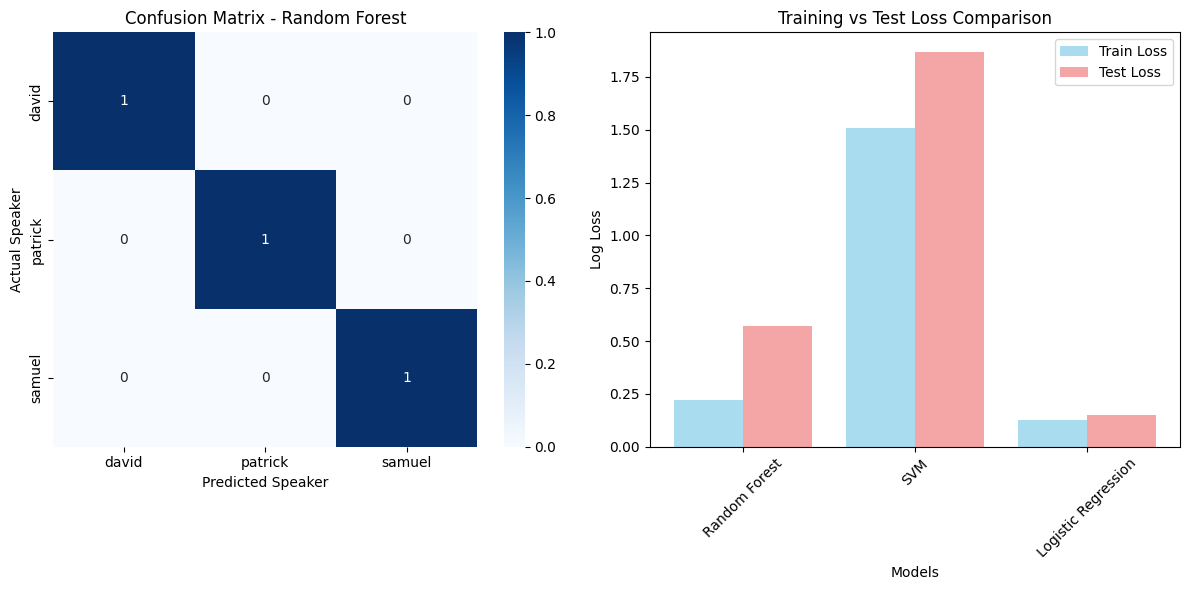


🔮 Testing prediction capability...
Sample Prediction Test:
  Actual: patrick
  Predicted: samuel
  Confidence: 0.620
  Result: ❌ Wrong

All speaker probabilities:
  david: 0.160
  patrick: 0.220
  samuel: 0.620

💾 Evaluated model stored for next cell


In [45]:
# Model Selection and Evaluation

def select_best_model(self):
    """Select the best model based on F1-score"""
    print("Selecting best model...")
    
    if not self.models:
        raise ValueError("No trained models available.")
    
    print("\n=== MODEL PERFORMANCE COMPARISON ===")
    
    comparison_data = []
    for name, result in self.models.items():
        comparison_data.append({
            'Model': name,
            'CV Score': result['cv_score'],
            'Test Accuracy': result['accuracy'],
            'F1-Score': result['f1_score'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'Train Loss': result['train_loss'], 
            'Test Loss': result['test_loss'],
            'Training Time (s)': result['training_time']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
    
    print(comparison_df.round(4).to_string(index=False))
    
    best_model_name = comparison_df.iloc[0]['Model']
    
    self.best_model_name = best_model_name
    self.best_model = self.models[best_model_name]['model']
    self.best_params = self.models[best_model_name]['best_params']
    
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"F1-Score: {self.models[best_model_name]['f1_score']:.4f}")
    print(f"Accuracy: {self.models[best_model_name]['accuracy']:.4f}")
    print(f"Test Loss: {self.models[best_model_name]['test_loss']:.4f}")
    
    return self.best_model, best_model_name

def comprehensive_evaluation(self):
    """Evaluate the best model"""
    print(f"\n=== EVALUATION: {self.best_model_name} ===")
    
    best_results = self.models[self.best_model_name]
    y_pred = best_results['predictions']
    y_pred_proba = best_results['probabilities']
    
    target_names = self.label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(self.y_test, y_pred, target_names=target_names))
    
    print("\n📉 LOSS METRICS ANALYSIS:")
    print(f"Training Loss:     {best_results['train_loss']:.6f}")
    print(f"Test Loss:         {best_results['test_loss']:.6f}")
    print(f"Loss Difference:   {best_results['test_loss'] - best_results['train_loss']:.6f}")
    
    print("\n🎯 Per-Class Confidence Analysis:")
    for i, speaker in enumerate(target_names):
        speaker_mask = (self.y_test == i)
        if speaker_mask.any():
            speaker_probs = y_pred_proba[speaker_mask, i]
            avg_confidence = np.mean(speaker_probs)
            print(f"{speaker:15s}: Avg Confidence = {avg_confidence:.3f}")
    
    cm = confusion_matrix(self.y_test, y_pred)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {self.best_model_name}')
    plt.xlabel('Predicted Speaker')
    plt.ylabel('Actual Speaker')
    
    plt.subplot(1, 2, 2)
    models = list(self.models.keys())
    train_losses = [self.models[m]['train_loss'] for m in models]
    test_losses = [self.models[m]['test_loss'] for m in models]
    
    x_pos = np.arange(len(models))
    plt.bar(x_pos - 0.2, train_losses, 0.4, label='Train Loss', alpha=0.7, color='skyblue')
    plt.bar(x_pos + 0.2, test_losses, 0.4, label='Test Loss', alpha=0.7, color='lightcoral')
    plt.xlabel('Models')
    plt.ylabel('Log Loss')
    plt.title('Training vs Test Loss Comparison')
    plt.xticks(x_pos, models, rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def predict_speaker(self, audio_features, return_probabilities=False):
    """Predict speaker from audio features"""
    if self.best_model is None:
        raise ValueError("Model not trained. Please run training first.")
    
    if audio_features.ndim == 1:
        audio_features = audio_features.reshape(1, -1)
    
    features_scaled = self.scaler.transform(audio_features)
    
    prediction = self.best_model.predict(features_scaled)[0]
    predicted_speaker = self.label_encoder.inverse_transform([prediction])[0]
    
    if return_probabilities:
        probabilities = self.best_model.predict_proba(features_scaled)[0]
        prob_dict = dict(zip(self.label_encoder.classes_, probabilities))
        return predicted_speaker, prob_dict
    
    return predicted_speaker

def save_model(self, model_dir='models'):
    """Save the trained model"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    model_path = os.path.join(model_dir, f'voiceprint_model_{timestamp}.pkl')
    scaler_path = os.path.join(model_dir, f'voiceprint_scaler_{timestamp}.pkl')
    encoder_path = os.path.join(model_dir, f'voiceprint_encoder_{timestamp}.pkl')
    
    joblib.dump(self.best_model, model_path)
    joblib.dump(self.scaler, scaler_path)
    joblib.dump(self.label_encoder, encoder_path)
    
    print(f"✅ Model saved successfully!")
    print(f"Model: {model_path}")
    print(f"Scaler: {scaler_path}")
    print(f"Encoder: {encoder_path}")
    
    return model_path, scaler_path, encoder_path

def save_model(self, model_dir='../models/audio/'):
    """Save the trained model (single version only)"""
    print("💾 Saving production model...")
    
    model_path = os.path.join(model_dir, 'voiceprint_model.pkl')
    scaler_path = os.path.join(model_dir, 'voiceprint_scaler.pkl')
    encoder_path = os.path.join(model_dir, 'voiceprint_encoder.pkl')
    metadata_path = os.path.join(model_dir, 'voiceprint_metadata.json')
    
    for path in [model_path, scaler_path, encoder_path, metadata_path]:
        if os.path.exists(path):
            os.remove(path)
    
    joblib.dump(self.best_model, model_path)
    joblib.dump(self.scaler, scaler_path)
    joblib.dump(self.label_encoder, encoder_path)
    
    metadata = {
        'training_timestamp': datetime.now().isoformat(),
        'model_name': self.best_model_name,
        'speakers': list(self.label_encoder.classes_),
        'feature_count': len(self.feature_names),
        'performance': {
            'accuracy': self.models[self.best_model_name]['accuracy'],
            'f1_score': self.models[self.best_model_name]['f1_score'],
            'precision': self.models[self.best_model_name]['precision'],
            'recall': self.models[self.best_model_name]['recall'],
            'train_loss': self.models[self.best_model_name]['train_loss'], 
            'test_loss': self.models[self.best_model_name]['test_loss']
        }
    }
    
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✅ Model saved successfully!")
    print(f"📁 Model files:")
    print(f"   • Model: voiceprint_model.pkl")
    print(f"   • Scaler: voiceprint_scaler.pkl") 
    print(f"   • Encoder: voiceprint_encoder.pkl")
    print(f"   • Metadata: voiceprint_metadata.json (includes loss metrics)")
    
    return model_path, scaler_path, encoder_path, metadata_path

VoiceprintVerificationModel.select_best_model = select_best_model
VoiceprintVerificationModel.comprehensive_evaluation = comprehensive_evaluation
VoiceprintVerificationModel.predict_speaker = predict_speaker
VoiceprintVerificationModel.save_model = save_model

print("Testing model selection and evaluation...")

try:
    if 'trained_model' in globals() and hasattr(trained_model, 'models') and trained_model.models:
        print("✅ Using trained model from previous cell")
        test_model = trained_model
        
        print("\n🏆 Selecting best model...")
        best_model, best_name = test_model.select_best_model()
        
        print("✅ Best model selection successful!")
        
        print("\n📈 Running comprehensive evaluation...")
        test_model.comprehensive_evaluation()
        
        print("\n🔮 Testing prediction capability...")
        
        if len(test_model.X_test_scaled) > 0:
            sample_features = test_model.X_test_scaled[0]
            actual_speaker = test_model.label_encoder.inverse_transform([test_model.y_test[0]])[0]
            
            predicted_speaker, probabilities = test_model.predict_speaker(
                sample_features, return_probabilities=True
            )
            
            print(f"Sample Prediction Test:")
            print(f"  Actual: {actual_speaker}")
            print(f"  Predicted: {predicted_speaker}")
            print(f"  Confidence: {probabilities[predicted_speaker]:.3f}")
            print(f"  Result: {'✅ Correct' if actual_speaker == predicted_speaker else '❌ Wrong'}")
            
            print(f"\nAll speaker probabilities:")
            for speaker, prob in sorted(probabilities.items()):
                print(f"  {speaker}: {prob:.3f}")
        
        globals()['evaluated_model'] = test_model
        print("\n💾 Evaluated model stored for next cell")
        
    else:
        print("❌ No trained model found. Please run cell 6 first.")
        
except Exception as e:
    print(f"❌ Evaluation test failed: {e}")
    import traceback
    traceback.print_exc()

Testing complete pipeline...
🎤 RUNNING COMPLETE VOICE VERIFICATION PIPELINE 🎤
1️⃣ Initializing model...
✅ VoiceprintVerificationModel initialized successfully!
2️⃣ Running complete pipeline...
🎤 VOICEPRINT VERIFICATION MODEL TRAINING 🎤
Loading and validating audio features data...
✅ Successfully loaded data with shape: (8, 16)

🔧 Normalizing speaker names...
Speaker names normalized:
  Before: ['David', 'david', 'patrick', 'samuel-approve-audio.mp4', 'samuel-approve.m4a', 'samuel-confirm-transaction-audio.mp4', 'samuel-confirm.m4a']
  After:  ['david', 'patrick', 'samuel']

=== DATA VALIDATION REPORT ===
Dataset shape: (8, 16)
Speakers: ['david', 'patrick', 'samuel']
Number of speakers: 3
Augmentation types: ['original']

Class distribution:
speaker
samuel     4
david      2
patrick    2
Name: count, dtype: int64

✅ Data validation completed successfully
Performing feature engineering...
=== FEATURE ENGINEERING ===
Original features: 14
Enhanced features: 16
Label encoding: {'david': 0

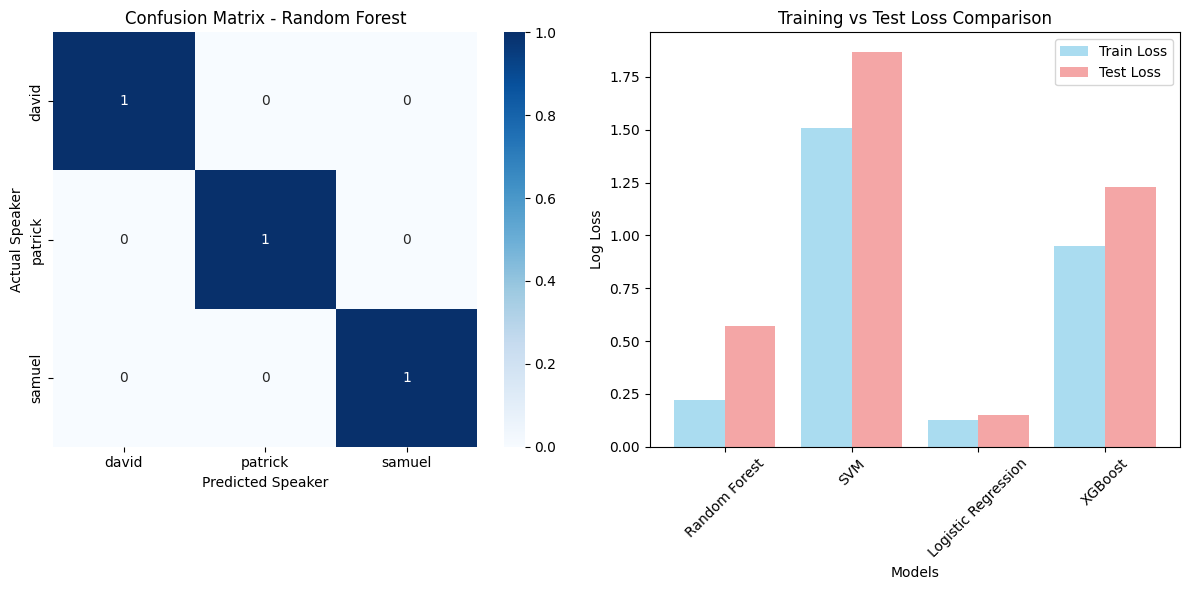

💾 Saving production model...
✅ Model saved successfully!
📁 Model files:
   • Model: voiceprint_model.pkl
   • Scaler: voiceprint_scaler.pkl
   • Encoder: voiceprint_encoder.pkl
   • Metadata: voiceprint_metadata.json (includes loss metrics)

🎉 PIPELINE COMPLETED! 🎉
Total time: 0.78 seconds
Best model: Random Forest
F1-Score: 1.0000

🎉 PIPELINE COMPLETED SUCCESSFULLY! 🎉
🏆 Best Model: Random Forest
📊 Performance Metrics:
   • Accuracy:  1.0000
   • F1-Score:  1.0000
   • Precision: 1.0000
   • Recall:    1.0000
⏱️  Training Time: 0.49 seconds

📁 Model Files Saved:
   1. voiceprint_model.pkl
   2. voiceprint_scaler.pkl
   3. voiceprint_encoder.pkl
   4. voiceprint_metadata.json

💾 Final model stored in 'final_voice_model' variable

✨ Your voice verification model is ready for production! ✨


In [46]:
# Complete Training Pipeline
def run_complete_pipeline(self):
    """Execute the complete training pipeline"""
    print("🎤 VOICEPRINT VERIFICATION MODEL TRAINING 🎤")
    print("=" * 50)
    
    start_time = time.time()
    
    try:
        # Load data
        self.load_and_validate_data()
        
        # Feature engineering
        self.engineer_features()
        
        # Train models
        self.train_and_optimize_models()
        
        # Select best model
        self.select_best_model()
        
        # Evaluate
        self.comprehensive_evaluation()
        
        # Save model
        model_paths = self.save_model()
        
        total_time = time.time() - start_time
        
        print(f"\n🎉 PIPELINE COMPLETED! 🎉")
        print(f"Total time: {total_time:.2f} seconds")
        print(f"Best model: {self.best_model_name}")
        print(f"F1-Score: {self.models[self.best_model_name]['f1_score']:.4f}")
        
        return {
            'best_model': self.best_model,
            'best_model_name': self.best_model_name,
            'model_paths': model_paths,
            'performance': self.models[self.best_model_name]
        }
        
    except Exception as e:
        print(f"❌ Pipeline failed: {e}")
        raise

VoiceprintVerificationModel.run_complete_pipeline = run_complete_pipeline

print("Testing complete pipeline...")

csv_path = '../data/outputs/audio_features.csv'

try:
    if os.path.exists(csv_path):
        print("🎤 RUNNING COMPLETE VOICE VERIFICATION PIPELINE 🎤")
        print("=" * 55)
        
        print("1️⃣ Initializing model...")
        voice_model = VoiceprintVerificationModel(csv_path=csv_path)
        
        print("2️⃣ Running complete pipeline...")
        results = voice_model.run_complete_pipeline()
        
        print("\n🎉 PIPELINE COMPLETED SUCCESSFULLY! 🎉")
        print("=" * 40)
        
        performance = results['performance']
        print(f"🏆 Best Model: {results['best_model_name']}")
        print(f"📊 Performance Metrics:")
        print(f"   • Accuracy:  {performance['accuracy']:.4f}")
        print(f"   • F1-Score:  {performance['f1_score']:.4f}")
        print(f"   • Precision: {performance['precision']:.4f}")
        print(f"   • Recall:    {performance['recall']:.4f}")
        print(f"⏱️  Training Time: {performance['training_time']:.2f} seconds")
        
        print(f"\n📁 Model Files Saved:")
        model_paths = results['model_paths']
        for i, path in enumerate(model_paths, 1):
            filename = os.path.basename(path)
            print(f"   {i}. {filename}")
        
        globals()['final_voice_model'] = voice_model
        print(f"\n💾 Final model stored in 'final_voice_model' variable")
        
        print(f"\n✨ Your voice verification model is ready for production! ✨")
        
    else:
        print(f"❌ Cannot run pipeline: {csv_path} not found")
        
except Exception as e:
    print(f"❌ Pipeline failed: {e}")
    import traceback
    traceback.print_exc()

In [47]:
# Cell 9: Model Loading Utility for Production Use
class VoiceVerificationSystem:
    """Production-ready voice verification system"""
    
    def __init__(self, model_path, scaler_path, encoder_path):
        """Load pre-trained model components"""
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)
        self.label_encoder = joblib.load(encoder_path)
        print("✅ Voice verification system loaded successfully!")
    
    def verify_speaker(self, audio_features, expected_speaker=None):
        """
        Verify if audio features match expected speaker
        
        Args:
            audio_features: Extracted MFCC features from audio
            expected_speaker: Expected speaker name (optional)
        
        Returns:
            dict: Verification results
        """
        if audio_features.ndim == 1:
            audio_features = audio_features.reshape(1, -1)
        
        features_scaled = self.scaler.transform(audio_features)
        
        prediction = self.model.predict(features_scaled)[0]
        probabilities = self.model.predict_proba(features_scaled)[0]
        
        predicted_speaker = self.label_encoder.inverse_transform([prediction])[0]
        confidence = probabilities[prediction]
        
        prob_dict = dict(zip(self.label_encoder.classes_, probabilities))
        
        result = {
            'predicted_speaker': predicted_speaker,
            'confidence': confidence,
            'probabilities': prob_dict,
            'verification_passed': False
        }
        
        if expected_speaker:
            result['expected_speaker'] = expected_speaker
            result['verification_passed'] = (predicted_speaker == expected_speaker and confidence > 0.5)
            result['match'] = predicted_speaker == expected_speaker
        
        return result
    
    def get_speaker_list(self):
        """Get list of known speakers"""
        return list(self.label_encoder.classes_)

print("✅ Voice verification system utility ready!")

✅ Voice verification system utility ready!


In [48]:
# Cell 10: Model Loading Utility for Production Use
class VoiceVerificationSystem:
    """Production-ready voice verification system"""
    
    def __init__(self, model_path, scaler_path, encoder_path):
        """Load pre-trained model components"""
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)
        self.label_encoder = joblib.load(encoder_path)
        print("✅ Voice verification system loaded successfully!")
    
    def verify_speaker(self, audio_features, expected_speaker=None):
        """
        Verify if audio features match expected speaker
        
        Args:
            audio_features: Extracted MFCC features from audio
            expected_speaker: Expected speaker name (optional)
        
        Returns:
            dict: Verification results
        """
        if audio_features.ndim == 1:
            audio_features = audio_features.reshape(1, -1)
        
        features_scaled = self.scaler.transform(audio_features)
        
        prediction = self.model.predict(features_scaled)[0]
        probabilities = self.model.predict_proba(features_scaled)[0]
        
        predicted_speaker = self.label_encoder.inverse_transform([prediction])[0]
        confidence = probabilities[prediction]
        
        prob_dict = dict(zip(self.label_encoder.classes_, probabilities))
        
        result = {
            'predicted_speaker': predicted_speaker,
            'confidence': confidence,
            'probabilities': prob_dict,
            'verification_passed': False
        }
        
        if expected_speaker:
            result['expected_speaker'] = expected_speaker
            result['verification_passed'] = (predicted_speaker == expected_speaker and confidence > 0.5)
            result['match'] = predicted_speaker == expected_speaker
        
        return result
    
    def get_speaker_list(self):
        """Get list of known speakers"""
        return list(self.label_encoder.classes_)

print("✅ Voice verification system utility ready!")

✅ Voice verification system utility ready!
